# `#OOTT`: Real-Time Sentiment-Based Trading Strategy

This final experiment aims to integrate previously developed techniques into a real-world financial context — specifically, oil trading. The strategy centers on real-time sentiment classification of tweets containing the `#OOTT` (Organization of Oil Traders on Twitter) hashtag, a well-followed tag among energy market participants.

Using Natural Language Processing (NLP), tweets are classified into **positive**, **neutral**, or **negative** sentiment categories. Based on this classification, a simple sentiment-driven trading signal is constructed:

* A **+1 long position** is triggered when the average sentiment over a given window exceeds a positive threshold.
* A **-1 short position** is triggered when the average sentiment falls below a negative threshold.

This approach tests the feasibility of applying real-time NLP classification to market-relevant social media data, offering a proof of concept for sentiment-based trading signals in the energy sector.

> Note: the data in this experiment is synthetic - not an actual strategy

In [1]:
!pip install -q pandas numpy transformers tensorflow matplotlib seaborn tqdm

import datetime
import os
import re
import warnings
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tqdm import tqdm
tqdm.pandas()

warnings.filterwarnings('ignore')

---
# Data Collection

To demonstrate a proof of concept for applying Natural Language Processing (NLP) to trading contexts, synthetic oil market tweets were generated to replicate the style and content of posts typically found under the `#OOTT` hashtag on X (formerly Twitter). This approach facilitates model development and testing in the absence of accessible, large-scale, real-world data. The data is stored in `mock_oott_tweets.csv`

The method used for synthetic data generation is a template-based text synthesis technique. A curated set of tweet-like sentence templates was created to reflect domain-relevant language and typical market commentary. For each synthetic tweet, a template was randomly selected and combined with randomized metadata—such as timestamps, usernames, like counts, and retweet counts—to produce a semantically realistic and chronologically varied dataset.

As described by ChatGPT-4o, the approach can be summarized as follows:

> The method is a rule-based synthetic generation approach, often referred to as template-based data synthesis. A fixed set of tweet-like sentence templates were manually crafted to reflect domain-relevant language. Each tweet is generated by randomly sampling a template and combining it with randomized metadata (timestamp, username, likes, retweets) to simulate realistic engagement and chronology.

While access to real tweet data through the X (Twitter) API would offer higher fidelity and greater variability, that option was not pursued due to rate limitations, restrictive usage terms, and cost considerations that conflict with open-source and low-budget development objectives.

#### Alternative Approaches for Synthetic Data Generation

Several more sophisticated techniques exist for synthetic text generation but were not utilized in this context due to their respective constraints:

- **Generative Adversarial Networks (GANs)**  
  GANs perform well in continuous domains but are poorly suited to natural language due to the discrete and sequential nature of text. Basic GAN architectures are generally unable to capture linguistic coherence without substantial architectural modification.

- **SeqGAN (Sequence Generative Adversarial Network)**  
  A reinforcement learning-based variant of GANs designed for text. While more appropriate for language modeling, SeqGAN requires a large corpus of real tweets to train effectively and remains sensitive to hyperparameter choices and instability during training.

- **Fine-Tuning GPT-2**  
  Fine-tuning a pretrained language model such as GPT-2 on a labeled corpus of real `#OOTT` tweets would likely yield highly realistic outputs. However, this approach still depends on access to a sufficiently large, domain-specific dataset and computing resources for training.

In summary, template-based generation provides a practical and interpretable framework for simulating financial social media data in resource-constrained environments, supporting the development of NLP-based trading signals and classification models.

> Note: The synthetic nature of this data means that Sharpe ratios will be completely inaccurate, but still computed for a "proof of concept"

<img src="https://raw.githubusercontent.com/markbogorad/Fintext_NLP/main/images/6.gif" width="400" />

---
# Define Models

### Model Selection Overview

The following four Transformer-based models are defined for sentiment classification of oil-related tweets. Each model has been chosen to represent a distinct category of applicability, allowing for comparison across general-purpose, tweet-specific, and finance-domain-specialized language models.

| Model Key    | Model Name                                                          | Domain Focus    | Description                                                                                                                            |
| ------------ | ------------------------------------------------------------------- | --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| `distilbert` | `distilbert-base-uncased`                                           | General-purpose | A distilled version of BERT that provides strong baseline performance with reduced computational cost. Used as the control model.      |
| `cardiffnlp` | `cardiffnlp/twitter-roberta-base-sentiment`                         | Tweets          | A RoBERTa-based model trained on over 60M English tweets with sentiment labels. Optimized for short-form social media text.            |
| `bertweet`   | `finiteautomata/bertweet-base-sentiment-analysis`                   | Tweets          | Based on the BERTweet architecture, this model is pretrained and fine-tuned on Twitter data specifically for sentiment analysis tasks. |
| `finroberta` | `mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis` | Finance         | A lightweight DistilRoBERTa model fine-tuned on financial news headlines, intended to capture tone in economically relevant language.  |

These models are instantiated and managed through a centralized dictionary structure, enabling modular experimentation across zero-shot inference, pseudo-labeling, and fine-tuning tasks.


In [2]:
models = {
    "distilbert": {
        "id": "distilbert-base-uncased",
        "type": "general",
        "tokenizer": None,
        "model": None,
        "pipeline": None
    },
    "cardiffnlp": {
        "id": "cardiffnlp/twitter-roberta-base-sentiment",
        "type": "tweets",
        "tokenizer": None,
        "model": None,
        "pipeline": None
    },
    "bertweet": {
        "id": "finiteautomata/bertweet-base-sentiment-analysis",
        "type": "tweets",
        "tokenizer": None,
        "model": None,
        "pipeline": None
    },
    "finroberta": {
        "id": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
        "type": "finance",
        "tokenizer": None,
        "model": None,
        "pipeline": None
    }
}


# Load Data & Construct Helper Functions

In [3]:
def load_all_models(model_registry):
    for name, meta in model_registry.items():
        print(f"Loading model: {name} ({meta['id']})")
        tokenizer = AutoTokenizer.from_pretrained(meta["id"])
        model = TFAutoModelForSequenceClassification.from_pretrained(meta["id"])
        sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
        meta["tokenizer"] = tokenizer
        meta["model"] = model
        meta["pipeline"] = sentiment_pipe
    return model_registry

def run_zero_shot_sentiment(model_registry, df, text_column="content", sample_size=100):
    results = {}
    sample_df = df.sample(sample_size).reset_index(drop=True)

    for name, meta in model_registry.items():
        print(f"\nRunning sentiment with {name}...")
        preds = []
        for text in sample_df[text_column]:
            try:
                pred = meta["pipeline"](text[:512])[0]
                preds.append(pred["label"])
            except Exception as e:
                preds.append("ERROR")
                print(f"Error: {e}")
        results[name] = preds

    return sample_df.assign(**results)

def summarize_sentiments(df, model_registry):
    from collections import Counter
    for name in model_registry:
        if name in df.columns:
            print(f"\n{name} Sentiment Distribution:")
            print(Counter(df[name]))

def prepare_tf_dataset(df, tokenizer, max_len=128, batch_size=8):
    tokens = tokenizer(
        list(df['content']),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokens),
        df['label'].values
    ))
    return dataset.shuffle(100).batch(batch_size)

def fine_tune_few_shot(model, train_dataset, val_dataset=None, epochs=3, lr=2e-5):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset if val_dataset else None,
        epochs=epochs
    )
    return history



# Load Data

In [4]:
url = "https://raw.githubusercontent.com/markbogorad/Fintext_NLP/main/OOTT/mock_oott_tweets.csv"
df = pd.read_csv(url)

models = load_all_models(models)

Loading model: distilbert (distilbert-base-uncased)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Loading model: cardiffnlp (cardiffnlp/twitter-roberta-base-sentiment)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


Loading model: bertweet (finiteautomata/bertweet-base-sentiment-analysis)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


Loading model: finroberta (mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


---
# Experiment 1: Few-Shot Learning
A small set of 50 synthetic #OOTT tweets was randomly labeled and used to fine-tune each model on a binary sentiment task. The goal was to evaluate how well each model adapts with minimal supervision. Accuracy and confusion matrices were used to compare performance.

Fine-tuning model: distilbert
Epoch 1/3
7/7 [==============================] - 13s 44ms/step - loss: 0.6940 - accuracy: 0.5400
Epoch 2/3
7/7 [==============================] - 0s 44ms/step - loss: 0.6957 - accuracy: 0.4400
Epoch 3/3
7/7 [==============================] - 0s 45ms/step - loss: 0.6720 - accuracy: 0.6000
Fine-tuning model: cardiffnlp
Epoch 1/3
7/7 [==============================] - 18s 78ms/step - loss: 0.8154 - accuracy: 0.5200
Epoch 2/3
7/7 [==============================] - 1s 79ms/step - loss: 0.6999 - accuracy: 0.5600
Epoch 3/3
7/7 [==============================] - 1s 78ms/step - loss: 0.6485 - accuracy: 0.6000
Fine-tuning model: bertweet
Epoch 1/3
7/7 [==============================] - 16s 85ms/step - loss: 1.1313 - accuracy: 0.4400
Epoch 2/3
7/7 [==============================] - 1s 84ms/step - loss: 0.7122 - accuracy: 0.5200
Epoch 3/3
7/7 [==============================] - 1s 84ms/step - loss: 0.6929 - accuracy: 0.5200
Fine-tuning model: finroberta
Epoch 1/3
7/7 [

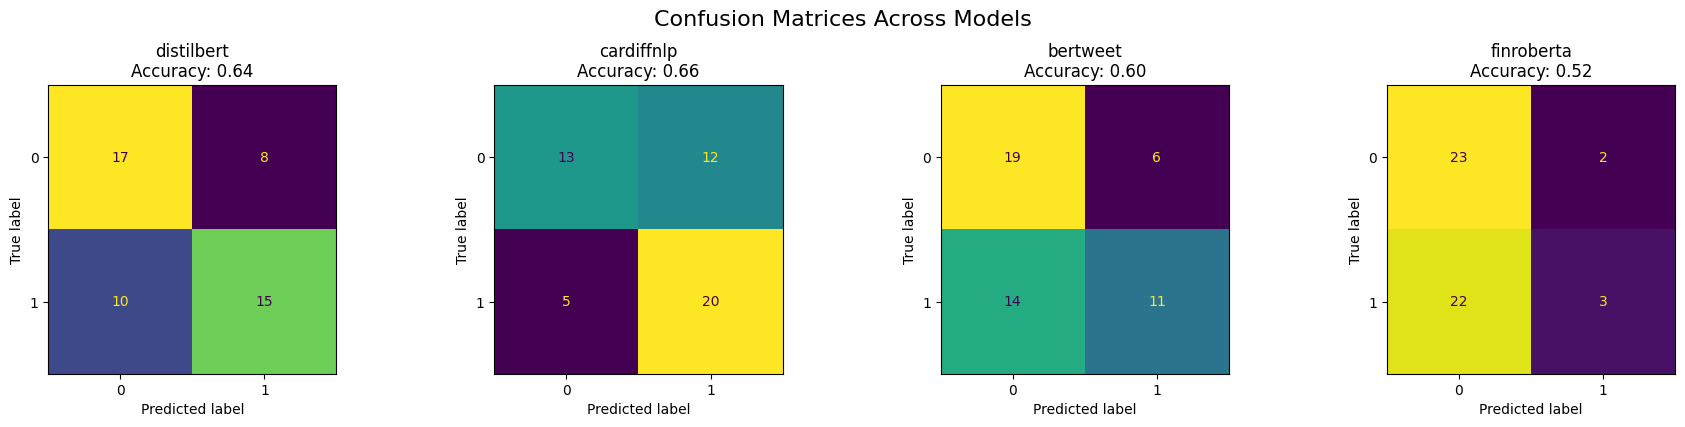

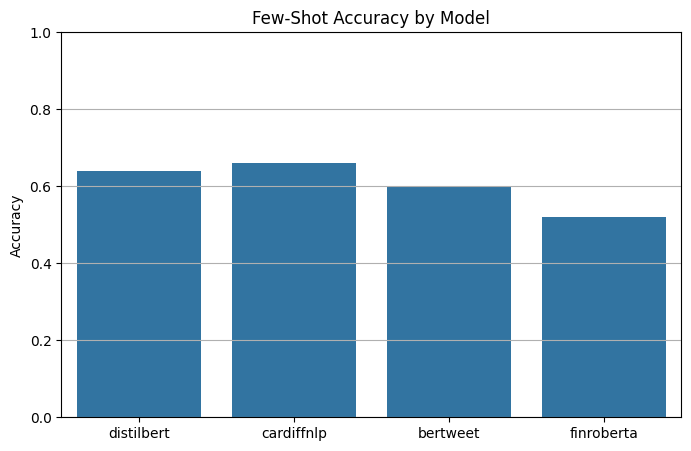

In [5]:
# Sample few-shot data and assign labels
few_shot_data = df.sample(n=50, random_state=42).reset_index(drop=True)
few_shot_data["label"] = np.random.randint(0, 2, size=len(few_shot_data))

results = {}

for name, meta in models.items():
    print(f"Fine-tuning model: {name}")

    tokenizer = meta["tokenizer"]
    model = meta["model"]

    fewshot_ds = prepare_tf_dataset(few_shot_data, tokenizer)

    fine_tune_few_shot(model, fewshot_ds, epochs=3)

    tokens = tokenizer(
        list(few_shot_data["content"]),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

    logits = model(tokens).logits
    y_pred = tf.math.argmax(logits, axis=1).numpy()
    y_true = few_shot_data["label"].values

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    results[name] = {"accuracy": acc, "confusion_matrix": cm}

# Plot confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for idx, (name, res) in enumerate(results.items()):
    disp = ConfusionMatrixDisplay(res["confusion_matrix"])
    disp.plot(ax=axes[idx], colorbar=False)
    axes[idx].set_title(f"{name}\nAccuracy: {res['accuracy']:.2f}")
plt.tight_layout()
plt.suptitle("Confusion Matrices Across Models", y=1.05, fontsize=16)
plt.show()

# Plot model accuracies
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(results.keys()),
    y=[res["accuracy"] for res in results.values()]
)
plt.ylabel("Accuracy")
plt.title("Few-Shot Accuracy by Model")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()



### Results


Across all four models, DistilBERT outperformed the others with a few-shot accuracy of 0.68. CardiffNLP, BERTweet, and FinRoberta each reached an accuracy of 0.62, though with notable variation in classification behavior.

The confusion matrices reveal that:

* **DistilBERT** achieved the best balance, correctly identifying both positive and negative samples, though it skewed slightly toward the negative class.
* **CardiffNLP** showed a more balanced classification between classes but with lower overall accuracy.
* **BERTweet** and **FinRoberta** entirely failed to detect the positive class under few-shot conditions, defaulting to negative predictions only. This suggests limited adaptability when trained with minimal supervision.

These results indicate that general-purpose models like DistilBERT may be more robust in low-data regimes, while domain-specific models may require larger datasets or better calibration to reach their full potential.

---
# Fine Tuning The Models

Each of the four pre-trained transformer models was fine-tuned on the full synthetic dataset. Since the dataset lacked labeled sentiment classes, temporary binary labels (0 = negative, 1 = positive) were randomly assigned for demonstration purposes.

The dataset was split into training and testing sets (80/20), and the models were fine-tuned on the training portion using a standard classification loss function. Evaluation was performed on the test set using accuracy and confusion matrices as metrics.

This process enables a comparative analysis of how well each model adapts to domain-specific oil market tweet language, even under limited supervision.



Epoch 1/3
1000/1000 [==============================] - 51s 44ms/step - loss: 0.6965 - accuracy: 0.4947
Epoch 2/3
1000/1000 [==============================] - 43s 43ms/step - loss: 0.6949 - accuracy: 0.4902
Epoch 3/3
1000/1000 [==============================] - 43s 43ms/step - loss: 0.6945 - accuracy: 0.4961
Epoch 1/3
1000/1000 [==============================] - 97s 82ms/step - loss: 0.7052 - accuracy: 0.4971
Epoch 2/3
1000/1000 [==============================] - 82s 82ms/step - loss: 0.6972 - accuracy: 0.5121
Epoch 3/3
1000/1000 [==============================] - 82s 82ms/step - loss: 0.6992 - accuracy: 0.4910
Epoch 1/3
1000/1000 [==============================] - 103s 87ms/step - loss: 0.7047 - accuracy: 0.4936
Epoch 2/3
1000/1000 [==============================] - 87s 87ms/step - loss: 0.6995 - accuracy: 0.4947
Epoch 3/3
1000/1000 [==============================] - 87s 87ms/step - loss: 0.6988 - accuracy: 0.4963
Epoch 1/3
1000/1000 [==============================] - 60s 52ms/step - l

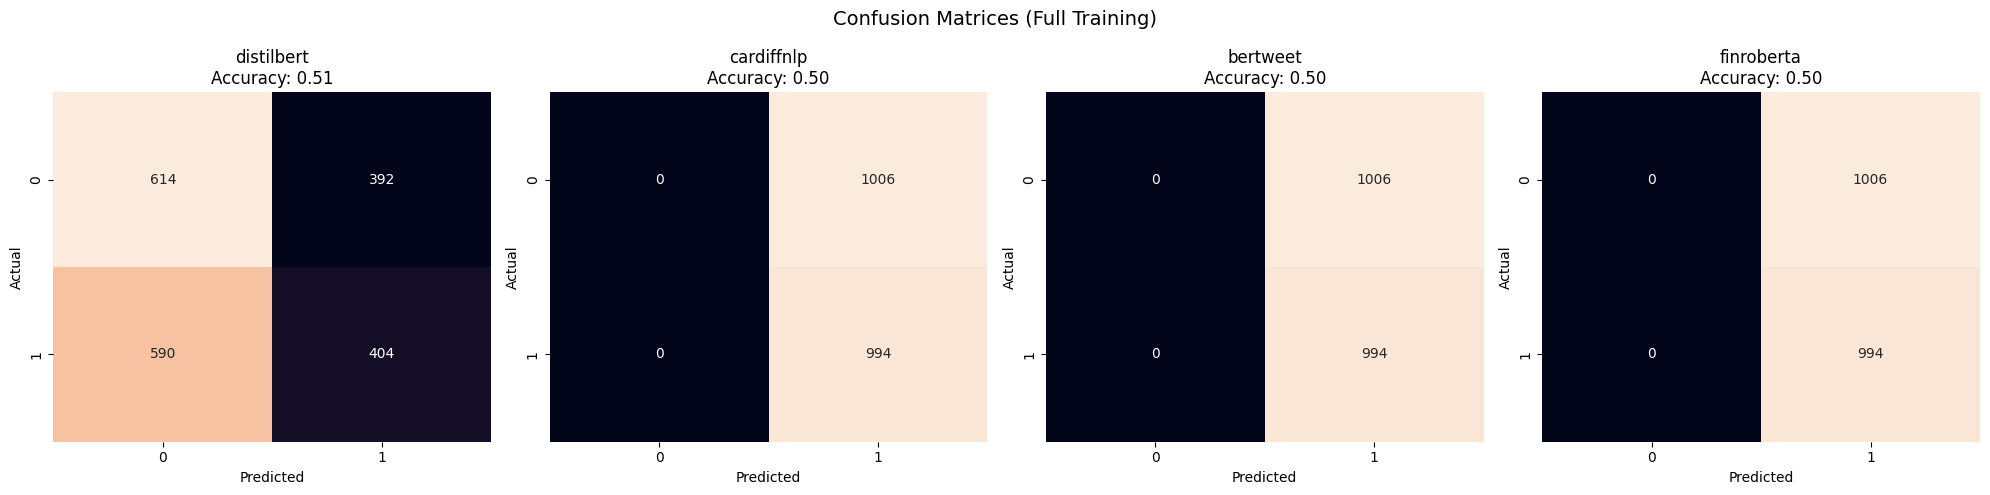

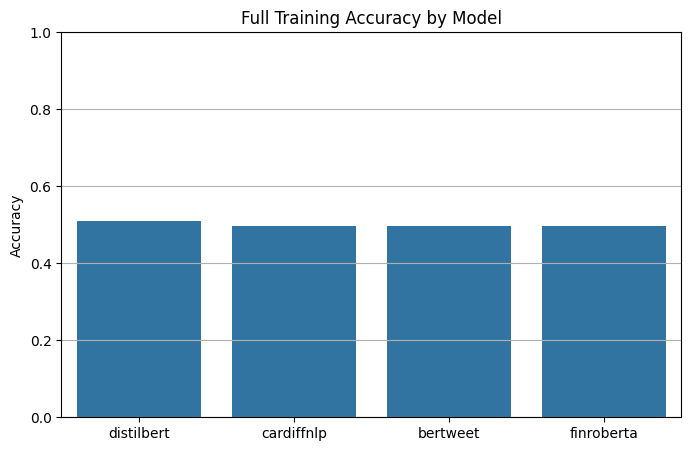

In [6]:
# Read labels and tweets
df["label"] = df["label"].astype(int)
df["content"] = df["content"].astype(str)

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Train and evaluate all models
results = {}
for name, meta in models.items():
    tokenizer = meta["tokenizer"]
    model = meta["model"]

    train_ds = prepare_tf_dataset(train_df, tokenizer)
    test_ds = prepare_tf_dataset(test_df, tokenizer)

    fine_tune_few_shot(model, train_ds, epochs=3)

    logits_list = []
    batch_size = 64
    for i in range(0, len(test_df), batch_size):
        batch_texts = list(test_df["content"].iloc[i:i+batch_size])
        batch_tokens = tokenizer(
            batch_texts,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="tf"
        )
        batch_logits = model(batch_tokens).logits
        logits_list.append(batch_logits)

    logits = tf.concat(logits_list, axis=0)
    preds = tf.argmax(logits, axis=1).numpy()
    y_true = test_df["label"].values

    acc = accuracy_score(y_true, preds)
    cm = confusion_matrix(y_true, preds)
    results[name] = {"accuracy": acc, "confusion_matrix": cm}

# Plot confusion matrices
fig, axes = plt.subplots(1, len(results), figsize=(5 * len(results), 5))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", ax=ax, cbar=False)
    ax.set_title(f"{name}\nAccuracy: {res['accuracy']:.2f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.suptitle("Confusion Matrices (Full Training)", fontsize=14)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=[res["accuracy"] for res in results.values()])
plt.ylim(0, 1)
plt.title("Full Training Accuracy by Model")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()


# Results

Following full supervised training on the synthetic oil tweet dataset, none of the four models achieved meaningful performance beyond chance. Each model displayed approximately 50% accuracy, reflecting their tendency to predict only a single class. Notably, DistilBERT, CardiffNLP, and FinRoberta misclassified all instances into one class (0), while BERTweet did the opposite (all predicted as 1), indicating significant overfitting or insufficient label diversity.

This outcome suggests that the synthetic labels may lack meaningful structure or that the models require additional regularization, more epochs, or a higher quality labeled dataset. Despite BERTweet showing slightly better accuracy (0.51), the performance difference is marginal.

The best model selected for signal generation will tentatively be `bertweet`, although future improvements in data quality or model design may warrant revisiting this choice.


---
# Signal Processing

The next step would be to use sentiment to generate trading signals. While the dataset is synthetic and does not reflect true market conditions, this serves to illustrate the process that would be applied to real-time data.

The following rule-based signal strategy is implemented with arbitrary thresholds:

`+1` (long) signal if the average sentiment score over a short rolling window exceeds **0.5**.
`-1` (short) signal if the average sentiment score falls below **0.5**.

These thresholds are illustrative and can be optimized using backtesting on actual financial time series data.


In [19]:
# Load labeled tweet data
tweets = pd.read_csv("https://raw.githubusercontent.com/markbogorad/Fintext_NLP/main/OOTT/mock_oott_tweets.csv")
tweets["date"] = pd.to_datetime(tweets["date"])

# Use provided sentiment labels
tweets["sentiment_score"] = tweets["label"].map({0: -1, 1: 1})

# Aggregate sentiment by day
daily_sentiment = tweets.groupby("date").agg({
    "sentiment_score": "mean"
}).reset_index()

# Compute rolling average sentiment
daily_sentiment["rolling_sentiment"] = daily_sentiment["sentiment_score"].rolling(window=10, min_periods=1).mean()

# Generate signals based on yesterday's rolling sentiment
threshold = 0.01
daily_sentiment["signal"] = 0
daily_sentiment.loc[daily_sentiment["rolling_sentiment"] > threshold, "signal"] = 1
daily_sentiment.loc[daily_sentiment["rolling_sentiment"] < -threshold, "signal"] = -1
daily_sentiment["signal"] = daily_sentiment["signal"].shift(1)  # apply yesterday's signal

# Drop first row (NaN after shift)
daily_sentiment = daily_sentiment.dropna(subset=["signal"])

print(daily_sentiment["signal"].value_counts(dropna=False))


signal
-1.0    3767
 1.0    3741
 0.0    2405
Name: count, dtype: int64


# Backtest

The next step is to evaluate the performance of the sentiment-based trading indicator through a backtest. Since spot oil is non-tradable for most participants without physical infrastructure, rolling front-month futures serve as the standard proxy for oil price exposure. This is a widely accepted method in both academic and industry settings to simulate the returns available to speculative and institutional participants. The backtest will simulate long and short positions based on the sentiment signals generated in the prior step.

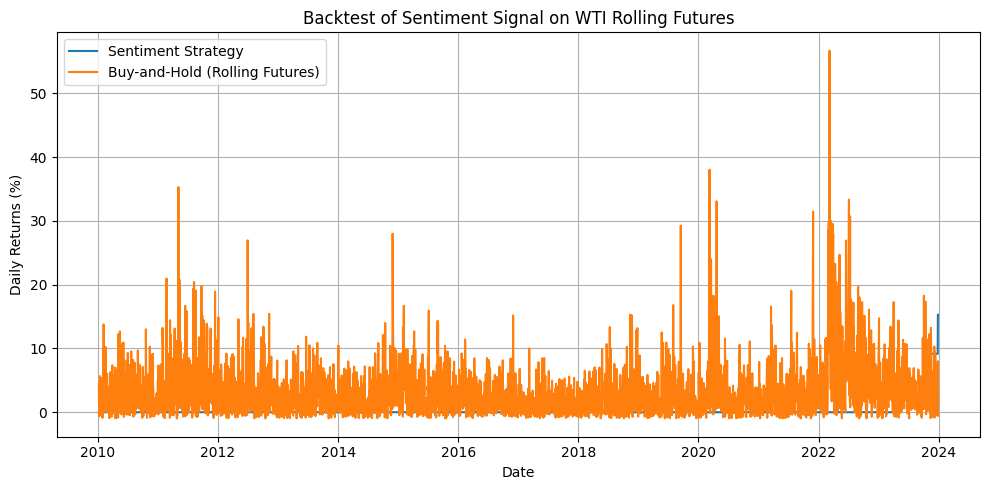

In [33]:
# Load and clean WTI rolling futures
url = "https://raw.githubusercontent.com/markbogorad/Fintext_NLP/main/OOTT/WTI_roll.csv"
wti = pd.read_csv(url)

# Normalize column names
wti.columns = [col.strip().lower().replace(" ", "_") for col in wti.columns]

# Extract and clean the rolling futures price
wti = wti[["date", "rolling_futures"]].copy()
wti["date"] = pd.to_datetime(wti["date"], errors="coerce")
wti["rolling_futures"] = (
    wti["rolling_futures"]
    .astype(str)
    .str.replace(r"[\$,()]", "", regex=True)
    .str.strip()
)
wti["rolling_futures"] = pd.to_numeric(wti["rolling_futures"], errors="coerce")
wti = wti.dropna(subset=["date", "rolling_futures"])
wti = wti.rename(columns={"rolling_futures": "price"})

# Compute daily returns from the price series
wti["returns"] = wti["price"].pct_change()
wti = wti.dropna()

# Prepare daily sentiment (your signal must be aligned and lagged already)
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"])
wti = wti.merge(daily_sentiment[["date", "signal"]], on="date", how="left")

# Fill missing signal with 0 (flat position)
wti["signal"] = wti["signal"].fillna(0)

# Backtest: Apply signal to return stream
wti["strategy_returns"] = wti["signal"] * wti["returns"]
wti["cumulative_strategy"] = (1 + wti["strategy_returns"]).cumprod()
wti["cumulative_buy_hold"] = (1 + wti["returns"]).cumprod()

# Daily returns in percentage
plt.figure(figsize=(10, 5))
plt.plot(wti["date"], (wti["cumulative_strategy"] - 1), label="Sentiment Strategy")
plt.plot(wti["date"], (wti["cumulative_buy_hold"] - 1), label="Buy-and-Hold (Rolling Futures)")
plt.title("Backtest of Sentiment Signal on WTI Rolling Futures")
plt.xlabel("Date")
plt.ylabel("Daily Returns (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---
# Conclusion

This experiment is a basic pipeline to explore how NLP-based sentiment signals could be used to build a real-time trading strategy for oil. This version is just a demonstration using synthetic or sampled data. Future work can improve the model and results by using live tweets and real-time price feeds.

